In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

In [1]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
np.random.seed(SEED)
tf.random.set_seed(SEED)  

In [2]:
import segmentation_models as sm


Segmentation Models: using `keras` framework.


In [3]:
from os import listdir, makedirs
from os.path import isfile, join, basename, splitext
from random import seed, shuffle
sm.set_framework('tf.keras')
cwd = os.getcwd()
cwd

'/content'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
%%capture
!unzip /content/drive/My\ Drive/Dataset.zip


In [8]:
%%capture
!unzip /content/drive/My\ Drive/file.zip

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# in case add rescale factor rescale= 1./255,
""" 
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
"""
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=0.2,
                                      width_shift_range=0.05,
                                      height_shift_range=0.05,
                                      shear_range=0.05,
                                      zoom_range=0.05,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=0.2,
                                      width_shift_range=0.05,
                                      height_shift_range=0.05,
                                      shear_range=0.05,
                                      zoom_range=0.05,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')
else:
    img_data_gen = ImageDataGenerator()
    mask_data_gen = ImageDataGenerator()

In [15]:
def read_rgb_mask(img_path):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr

In [16]:
from PIL import Image



class CustomDataset(tf.keras.utils.Sequence):

 

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256]):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'Splits', 'valid.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, 'Images/', curr_filename + '.png'))
    mask = Image.fromarray(read_rgb_mask(os.path.join(self.dataset_dir, 'Masks/', curr_filename + '.png')))

    # Resize image and mask
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    
    img_arr = np.array(img)
    mask_arr = np.array(mask)



    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [ ]:
from os import listdir, makedirs
from os.path import isfile, join, basename, splitext
from random import seed, shuffle

def split_dataset(training_dir, split_dir, training_percentage=0.90):
    """
    Starting from a training directory, creates a split directory
    with two text files, enumerating the images present in the 
    training and the validation set. 
    """

    seed(1234)

    file_names = [f for f in listdir(training_dir) if isfile(join(training_dir, f))]
    shuffle(file_names)

    split = int(len(file_names)*training_percentage)
    train_file_names = "\n".join([splitext(basename(f))[0] for f in file_names[:split]])
    valid_file_names = "\n".join([splitext(basename(f))[0] for f in file_names[split:]])

    makedirs(split_dir)
    with open(join(split_dir, './train.txt'), 'w') as train:
        train.write(train_file_names)
    with open(join(split_dir, './valid.txt'), 'w') as valid:
        valid.write(valid_file_names)



dataset_dir = os.path.join("/content/Development_Dataset/Training/Roseau/Mais")
split_dataset(join(dataset_dir, 'Images'), join(dataset_dir, 'Splits'))

In [20]:
from tensorflow.keras.applications.efficientnet import preprocess_input 
import os
img_h = 256
img_w = 256

num_classes = 3
dataset_dir = "/content/Development_Dataset/Training/Roseau/Mais"


# Set preprocess_input = None to display original image
dataset = CustomDataset(dataset_dir, 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=preprocess_input)
dataset_valid = CustomDataset(dataset_dir, 'validation', 
                              preprocessing_function=preprocess_input)


In [21]:
bs = 8 # batch size try 3

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

In [22]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, num_classes)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

[0. 1. 2.]


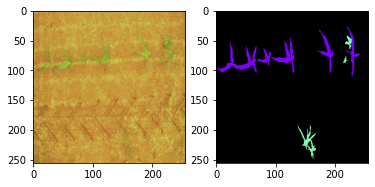

In [23]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, num_classes + 1):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

In [24]:
model = sm.Unet("efficientnetb5", classes=3, activation='softmax')

# Visualize created model as a table
model.summary()

115515392/115515256 [==============================] - 1s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 4 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 4 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 4 0           stem_bn[0][0]                    
____________________

## Prepare the model for training

In [27]:
import os
from datetime import datetime

"""
cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'drive/My Drive/Keras4/', 'b5_unet')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'b5_unet'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    


# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)
"""
callbacks = []

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
    callbacks.append(es_callback)




# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

In [28]:
# Optimization params

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1, num_classes): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
metrics = ['accuracy', meanIoU]
# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Training with callbacks

In [29]:
model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(dataset),
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid), 
          callbacks=callbacks)

Epoch 1/100
81/81 [==============================] - 131s 2s/step - loss: 0.8077 - accuracy: 0.7380 - meanIoU: 0.1269 - val_loss: 0.5083 - val_accuracy: 0.8034 - val_meanIoU: 0.0948
Epoch 2/100
81/81 [==============================] - 126s 2s/step - loss: 0.3701 - accuracy: 0.9659 - meanIoU: 0.3352 - val_loss: 0.3781 - val_accuracy: 0.9561 - val_meanIoU: 0.2247
Epoch 3/100
81/81 [==============================] - 124s 2s/step - loss: 0.2152 - accuracy: 0.9758 - meanIoU: 0.4785 - val_loss: 0.2146 - val_accuracy: 0.9684 - val_meanIoU: 0.4070
Epoch 4/100
81/81 [==============================] - 125s 2s/step - loss: 0.1520 - accuracy: 0.9809 - meanIoU: 0.5995 - val_loss: 0.1521 - val_accuracy: 0.9694 - val_meanIoU: 0.4253
Epoch 5/100
81/81 [==============================] - 125s 2s/step - loss: 0.1152 - accuracy: 0.9844 - meanIoU: 0.6822 - val_loss: 0.1329 - val_accuracy: 0.9679 - val_meanIoU: 0.4008
Epoch 6/100
81/81 [==============================] - 124s 2s/step - loss: 0.0909 - accurac

## Test model

## Compute prediction

In [ ]:
model.save('/content/drive/MyDrive/model_roseau_b5_unet_mais.h5')

In [30]:
iterator = iter(valid_dataset)

<class 'tensorflow.python.framework.ops.EagerTensor'>


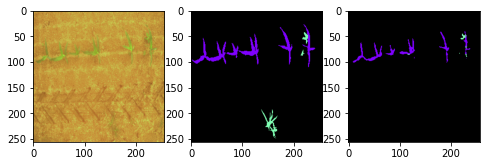

In [31]:
# Show original, correct, predicted (validation)

fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)
print(type(image))
image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...] #256*256
predicted_class.shape

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, num_classes):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, num_classes):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()

In [71]:
# Compute predictions

from os import listdir
from os.path import isfile, join, basename, splitext

# CustomTestDataset to load test images
# Specify the full path to the folder containing the images
class CustomTestDataset(tf.keras.utils.Sequence):

    def __init__(self, dataset_dir, img_generator=None, 
              preprocessing_function=None, out_shape=[img_h, img_w]):

      subset_filenames = [splitext(basename(f))[0] for f in 
                                                listdir(dataset_dir) if isfile(join(dataset_dir, f))]

      extension = [splitext(basename(f))[1] for f in 
                                                listdir(dataset_dir) if isfile(join(dataset_dir, f))]

      self.dataset_dir = dataset_dir
      self.subset_filenames = subset_filenames
      self.img_generator = img_generator
      self.extension = extension
      self.preprocessing_function = preprocessing_function
      self.out_shape = out_shape


    def __len__(self):
        return len(self.subset_filenames)


    def get_original_size(self, index):
        curr_filename = self.subset_filenames[index]
        img = Image.open(os.path.join(self.dataset_dir, curr_filename + self.extension[index]))
        width, height = img.size

        return [height, width]


    def __getitem__(self, index):
        # Read Image
        curr_filename = self.subset_filenames[index]
        img = Image.open(os.path.join(self.dataset_dir, curr_filename + self.extension[index]))

        # Resize image and mask
        img = img.resize(self.out_shape)
        img_arr = np.array(img)

        if self.preprocessing_function is not None:
            img_arr = self.preprocessing_function(img_arr)

        return img_arr


    def get_name(self, index):
        return self.subset_filenames[index]

In [72]:
import json
from prepare_submission import rle_encode
test_dir = '/content/Development_Dataset/Test_Dev/'
submission_dict = {}
for dataset in os.listdir(test_dir):
  for plant in os.listdir(os.path.join(test_dir,dataset)):
    directory = os.path.join(test_dir,dataset,plant,"Images")
    test_dataset = CustomTestDataset(directory, preprocessing_function=preprocess_input)
    temp = {}
    for i in range(test_dataset.__len__()):
        image = test_dataset.__getitem__(i)
        img_name = test_dataset.get_name(i)
        original_h, original_w = test_dataset.get_original_size(i)

        prediction = model.predict(tf.expand_dims(image, axis=0))
        mask_arr = tf.argmax(prediction, -1)[0, ...] # (256, 256)
        mask_arr = tf.expand_dims(mask_arr, axis=2)
        print(mask_arr.shape)
        mask_arr = tf.image.resize(mask_arr, (original_h, original_w),                          
                                    method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        mask_arr = np.array(mask_arr)

        temp[img_name] = {}
        temp[img_name]['shape'] = [original_h, original_w]
        temp[img_name]['team'] = dataset
        temp[img_name]['crop'] = plant
        temp[img_name]['segmentation'] = {}

        rle_encoded_crop = rle_encode(mask_arr == 1)
        rle_encoded_weed = rle_encode(mask_arr == 2)

        temp[img_name]['segmentation']['crop'] = rle_encoded_crop
        temp[img_name]['segmentation']['weed'] = rle_encoded_weed
      
    submission_dict.update(temp)
with open('./submission.json', 'w') as f:
    json.dump(submission_dict, f)

(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 